In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import holidays
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
%matplotlib notebook

In [2]:
# Constant
FIG_SIZE = (16, 10)

In [3]:
cb_target = [['CB Third Floor'], ['CB First Floor', 'CB Second Floor']]
cb_flat = sum(cb_target, [])
cb_flat

['CB Third Floor', 'CB First Floor', 'CB Second Floor']

In [4]:
dataset = pd.read_csv('AVGpower-1.csv', sep=';', parse_dates=['DateTime'])
dataset = dataset.astype({'AvgP':'int16', 'AvgT':'float32', 'AvgH':'float32'})
dataset

,DateTime,CbTagName,AvgP,AvgT,AvgH
0,2017-01-01 00:15:00,Bridge,0,0.0,0.000000
1,2017-02-06 00:00:00,CB Second Floor,0,3.5,98.599998
2,2017-02-06 00:00:00,CB First Floor,0,3.5,98.599998
3,2017-02-06 00:00:00,CB Backup A,0,3.5,98.599998
4,2017-02-06 00:00:00,CB Back Up C,0,3.5,98.599998
...,...,...,...,...,...
437559,2019-04-10 15:30:00,CB Backup A,0,18.1,52.599998
437560,2019-04-10 15:30:00,CB First Floor,68,18.1,52.599998
437561,2019-04-10 15:30:00,CB Back Up C,0,18.1,52.599998
437562,2019-04-10 15:30:00,Bridge,0,18.1,52.599998


In [5]:
# Preparazione dataset
train = dataset[dataset['CbTagName']=='CB First Floor'].set_index('DateTime')
d1 = dataset[dataset['CbTagName']=='CB Second Floor'].set_index('DateTime')
d2 = dataset[dataset['CbTagName']=='CB Third Floor'].set_index('DateTime')
train = train.join(d1, lsuffix='', rsuffix='2', how='inner')
train = train.join(d2, lsuffix='1', rsuffix='3', how='inner')
train.drop(columns=['AvgT2', 'AvgT3', 'AvgH2', 'AvgH3', 'CbTagName1', 'CbTagName2', 'CbTagName3'], inplace=True)
train.rename(columns={'AvgT1':'AvgT', 'AvgH1':'AvgH'}, inplace=True)
train['DateTime'] = train.index

In [6]:
# aggiunta punti mancanti
new_row = {name:[] for name in train.columns}
for date in pd.date_range(start='2017-02-08', end='2017-02-15', freq='15Min'):
    if date not in train['DateTime']:
        print(date)
        new_row['DateTime'].append(date)
        for name in train.columns:
            if name != 'DateTime':
                new_row[name].append(np.nan)

train = pd.concat([train, pd.DataFrame(new_row)])
train = train.set_index('DateTime')
train.interpolate(inplace=True)
train['DateTime'] = train.index

new_row = {name:[] for name in train.columns}
for date in pd.date_range(start='2017-02-15', end=train['DateTime'].max(), freq='15Min'):
    if date not in train['DateTime']:
        print(date)
        new_row['DateTime'].append(date)
        for name in train.columns:
            if name != 'DateTime':
                new_row[name].append(np.nan)
train = pd.concat([train, pd.DataFrame(new_row)])
train = train.set_index('DateTime')

train.sort_index(inplace=True)

for i in range(672, len(train)):
    if np.isnan(train.iloc[i].AvgP1):
        train.iloc[i] = train.iloc[i-672]
train['DateTime'] = train.index

2017-02-08 02:15:00
2017-02-12 00:00:00
2017-02-12 18:00:00
2017-02-12 18:30:00
2017-02-12 19:15:00
2017-02-12 19:45:00
2017-02-12 21:00:00
2017-02-13 04:15:00
2017-02-13 05:45:00
2017-02-13 06:15:00
2017-02-13 06:45:00
2017-02-13 07:15:00
2017-02-13 08:15:00
2017-02-13 08:45:00
2017-02-13 09:15:00
2017-02-16 00:00:00
2017-02-16 21:30:00
2017-02-16 22:15:00
2017-02-16 23:15:00
2017-02-17 00:45:00
2017-02-17 06:15:00
2017-02-17 07:30:00
2017-02-17 08:30:00
2017-02-17 10:00:00
2017-02-22 00:00:00
2017-02-22 18:30:00
2017-02-23 03:15:00
2017-02-23 03:45:00
2017-03-08 09:15:00
2017-03-08 12:30:00
2017-03-11 00:00:00
2017-03-11 14:15:00
2017-03-11 14:45:00
2017-03-11 23:00:00
2017-03-12 01:15:00
2017-03-12 02:00:00
2017-03-17 16:45:00
2017-03-17 17:15:00
2017-03-17 19:15:00
2017-03-17 19:30:00
2017-03-21 11:15:00
2017-03-22 12:30:00
2017-03-22 12:45:00
2017-03-22 13:00:00
2017-03-24 00:00:00
2017-03-24 20:15:00
2017-03-25 04:15:00
2017-03-25 04:45:00
2017-03-25 06:45:00
2017-03-26 02:15:00


2017-08-21 06:00:00
2017-08-21 06:15:00
2017-08-21 06:30:00
2017-08-21 06:45:00
2017-08-21 07:00:00
2017-08-21 07:15:00
2017-08-21 07:30:00
2017-08-21 07:45:00
2017-08-21 08:00:00
2017-08-21 08:15:00
2017-08-21 08:30:00
2017-08-21 08:45:00
2017-08-21 09:00:00
2017-08-21 09:15:00
2017-08-21 09:30:00
2017-08-21 09:45:00
2017-08-29 09:30:00
2017-09-01 22:00:00
2017-09-01 22:15:00
2017-09-03 00:00:00
2017-09-04 07:00:00
2017-09-08 10:30:00
2017-09-08 10:45:00
2017-09-08 11:00:00
2017-09-08 11:15:00
2017-09-08 11:30:00
2017-09-08 11:45:00
2017-09-08 12:00:00
2017-09-08 12:15:00
2017-09-17 00:00:00
2017-09-17 13:15:00
2017-09-17 13:30:00
2017-09-17 13:45:00
2017-09-17 14:00:00
2017-09-17 14:15:00
2017-09-17 14:30:00
2017-09-17 14:45:00
2017-09-17 15:00:00
2017-09-17 15:15:00
2017-09-17 15:30:00
2017-09-17 15:45:00
2017-09-17 16:00:00
2017-09-17 16:15:00
2017-09-17 16:30:00
2017-09-17 16:45:00
2017-09-17 17:00:00
2017-09-17 17:15:00
2017-09-17 17:30:00
2017-09-17 17:45:00
2017-09-17 18:00:00


2018-02-09 07:45:00
2018-02-10 09:30:00
2018-02-10 09:45:00
2018-02-10 10:30:00
2018-02-10 10:45:00
2018-02-10 11:30:00
2018-02-10 11:45:00
2018-02-10 12:30:00
2018-02-10 12:45:00
2018-02-10 13:30:00
2018-02-10 13:45:00
2018-02-10 14:00:00
2018-02-10 14:30:00
2018-02-10 14:45:00
2018-02-10 15:00:00
2018-02-10 15:15:00
2018-02-10 15:30:00
2018-02-10 15:45:00
2018-02-10 16:00:00
2018-02-10 16:15:00
2018-02-10 16:30:00
2018-02-10 16:45:00
2018-02-10 17:00:00
2018-02-10 17:15:00
2018-02-10 17:30:00
2018-02-10 17:45:00
2018-02-10 18:00:00
2018-02-10 18:15:00
2018-02-10 18:30:00
2018-02-10 18:45:00
2018-02-10 19:00:00
2018-02-10 19:15:00
2018-02-10 19:30:00
2018-02-10 19:45:00
2018-02-10 20:00:00
2018-02-10 20:15:00
2018-02-10 20:30:00
2018-02-10 20:45:00
2018-02-10 21:00:00
2018-02-10 21:15:00
2018-02-10 21:30:00
2018-02-10 21:45:00
2018-02-10 22:00:00
2018-02-10 22:15:00
2018-02-10 22:30:00
2018-02-10 22:45:00
2018-02-10 23:00:00
2018-02-10 23:15:00
2018-02-10 23:30:00
2018-02-10 23:45:00


2018-06-11 04:45:00
2018-06-20 12:45:00
2018-06-21 03:15:00
2018-06-21 23:30:00
2018-06-22 09:45:00
2018-06-22 12:30:00
2018-06-22 14:15:00
2018-06-22 15:00:00
2018-07-02 16:15:00
2018-07-03 00:00:00
2018-07-03 01:45:00
2018-07-03 12:00:00
2018-07-03 15:45:00
2018-07-03 18:15:00
2018-07-03 21:45:00
2018-07-04 00:45:00
2018-07-04 01:15:00
2018-07-10 19:15:00
2018-07-11 21:15:00
2018-07-12 10:30:00
2018-07-15 02:45:00
2018-07-15 05:30:00
2018-07-15 08:00:00
2018-07-15 08:30:00
2018-07-15 11:45:00
2018-07-22 00:00:00
2018-07-22 21:00:00
2018-07-22 22:00:00
2018-07-23 04:30:00
2018-07-23 05:00:00
2018-07-23 06:30:00
2018-07-23 07:15:00
2018-07-24 00:30:00
2018-07-24 00:45:00
2018-07-24 01:00:00
2018-07-24 01:15:00
2018-07-24 01:30:00
2018-07-24 01:45:00
2018-07-24 02:00:00
2018-07-24 02:15:00
2018-07-24 02:30:00
2018-07-24 02:45:00
2018-07-24 03:00:00
2018-07-24 03:15:00
2018-07-24 03:30:00
2018-07-24 03:45:00
2018-07-24 04:00:00
2018-07-24 04:15:00
2018-07-24 04:30:00
2018-07-24 04:45:00


2018-08-15 23:00:00
2018-08-15 23:15:00
2018-08-15 23:30:00
2018-08-15 23:45:00
2018-08-16 00:00:00
2018-08-16 00:15:00
2018-08-16 00:30:00
2018-08-16 00:45:00
2018-08-16 01:00:00
2018-08-16 01:15:00
2018-08-16 01:30:00
2018-08-16 01:45:00
2018-08-16 02:00:00
2018-08-16 02:15:00
2018-08-16 02:30:00
2018-08-16 02:45:00
2018-08-16 03:00:00
2018-08-16 03:15:00
2018-08-16 03:30:00
2018-08-16 03:45:00
2018-08-16 04:00:00
2018-08-16 04:15:00
2018-08-16 04:30:00
2018-08-16 04:45:00
2018-08-16 05:00:00
2018-08-16 05:15:00
2018-08-16 05:30:00
2018-08-16 05:45:00
2018-08-16 06:00:00
2018-08-16 06:15:00
2018-08-16 06:30:00
2018-08-16 06:45:00
2018-08-16 07:00:00
2018-08-16 07:15:00
2018-08-16 07:30:00
2018-08-16 07:45:00
2018-08-16 08:00:00
2018-08-16 08:15:00
2018-08-16 08:30:00
2018-08-16 08:45:00
2018-08-16 09:00:00
2018-08-16 09:15:00
2018-08-16 09:30:00
2018-08-16 09:45:00
2018-08-16 10:00:00
2018-08-16 10:15:00
2018-08-16 10:30:00
2018-08-16 10:45:00
2018-08-16 11:00:00
2018-08-16 11:15:00


2018-08-31 20:15:00
2018-09-03 10:00:00
2018-09-03 10:30:00
2018-09-14 15:15:00
2018-09-14 16:45:00
2018-09-14 21:45:00
2018-09-25 00:00:00
2018-09-26 04:00:00
2018-10-05 00:00:00
2018-10-05 13:30:00
2018-10-05 15:15:00
2018-10-05 21:45:00
2018-10-05 23:00:00
2018-10-05 23:15:00
2018-10-06 03:00:00
2018-10-06 03:15:00
2018-10-06 03:30:00
2018-10-06 03:45:00
2018-10-06 04:00:00
2018-10-06 04:15:00
2018-10-06 04:30:00
2018-10-06 04:45:00
2018-10-06 05:00:00
2018-10-06 05:15:00
2018-10-06 05:30:00
2018-10-06 05:45:00
2018-10-06 06:00:00
2018-10-06 06:15:00
2018-10-06 06:30:00
2018-10-06 06:45:00
2018-10-06 07:00:00
2018-10-06 07:15:00
2018-10-06 07:30:00
2018-10-06 07:45:00
2018-10-06 08:00:00
2018-10-06 08:15:00
2018-10-06 08:30:00
2018-10-06 08:45:00
2018-10-06 09:00:00
2018-10-06 09:15:00
2018-10-06 09:30:00
2018-10-06 09:45:00
2018-10-06 10:00:00
2018-10-06 10:15:00
2018-10-06 10:30:00
2018-10-06 10:45:00
2018-10-06 11:00:00
2018-10-06 11:15:00
2018-10-06 11:30:00
2018-10-06 11:45:00


In [7]:
# giorni di vacanza
holidays_it = holidays.Italy()
train['holidays'] = train['DateTime'].apply(lambda x: x in holidays_it).astype('int8')
# giorno della settimana
train['dayofweek'] = train['DateTime'].dt.dayofweek

# Dati strani
04-06-2017 <br>
05-06-2017 <br>
11-06-2017 <br>
12-06-2017 <br>

<IPython.core.display.Javascript object>


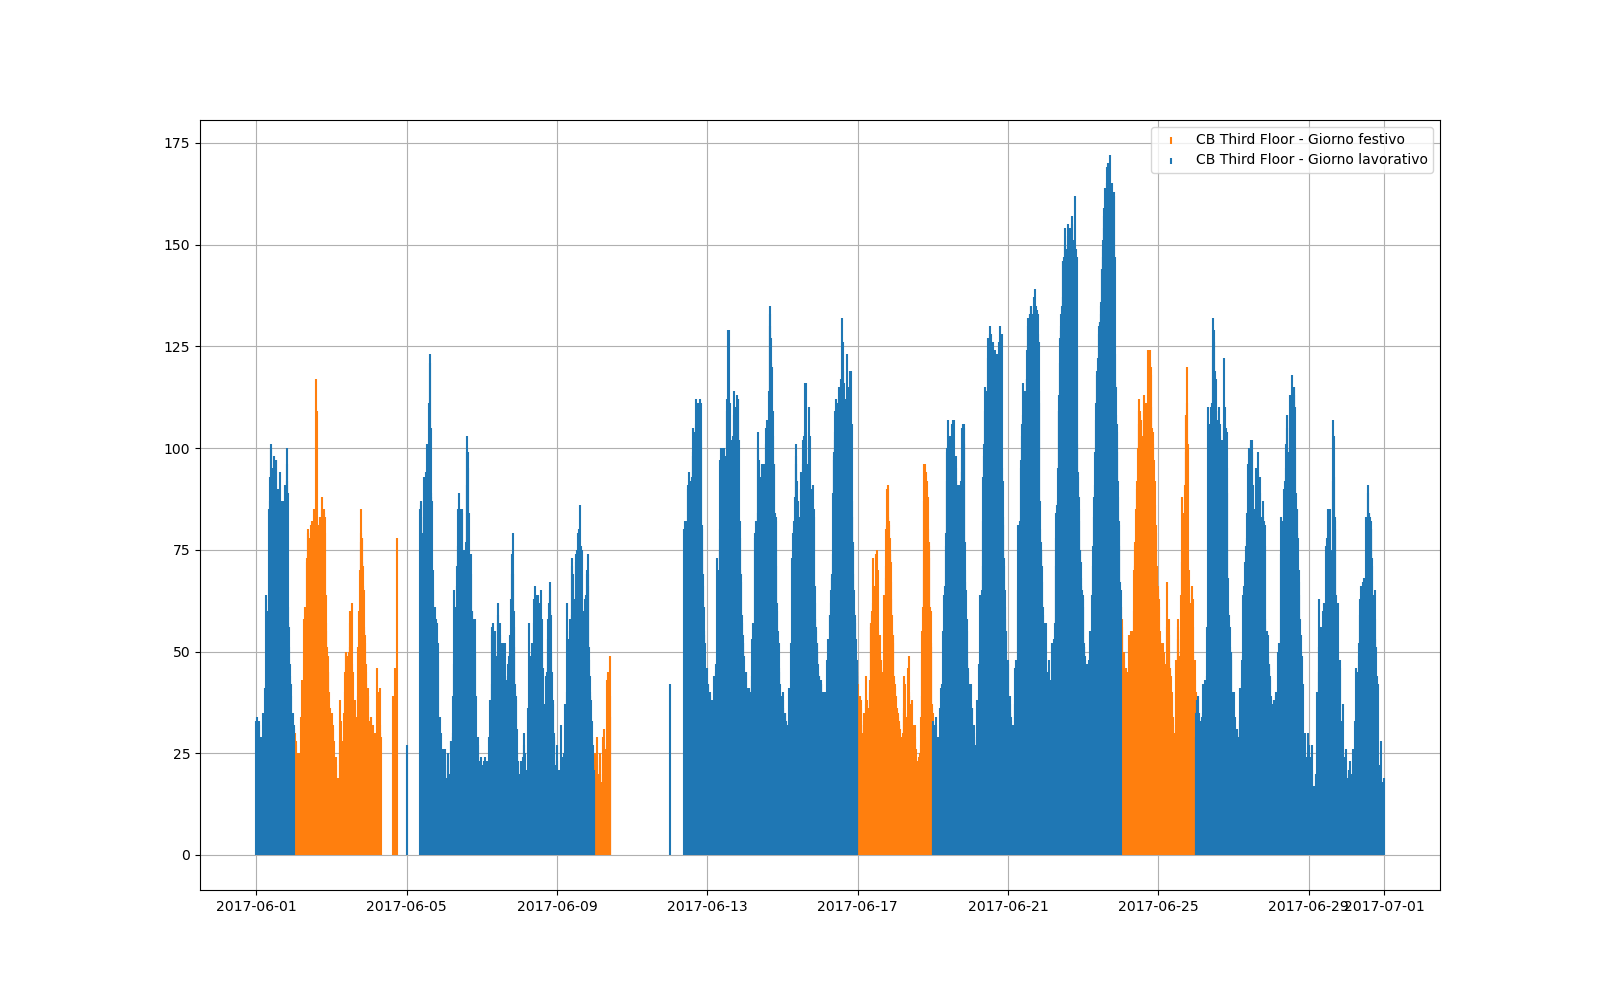

In [8]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
curr_dataset = train
curr_dataset = curr_dataset[curr_dataset['DateTime'].dt.year == 2017]
curr_dataset = curr_dataset[(curr_dataset['DateTime'].dt.month == 6)]


curr_holidays = curr_dataset[(curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5)]
curr_not_holidays = curr_dataset[~((curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5))]


ax.stem(curr_holidays.index, curr_holidays['AvgP3'], label='CB Third Floor - Giorno festivo', linefmt='C1', markerfmt=' ', basefmt=' ')
ax.stem(curr_not_holidays.index, curr_not_holidays['AvgP3'], label='CB Third Floor - Giorno lavorativo', linefmt='C0', markerfmt=' ', basefmt=' ')

ax.grid()
ax.legend()
plt.show()


<IPython.core.display.Javascript object>


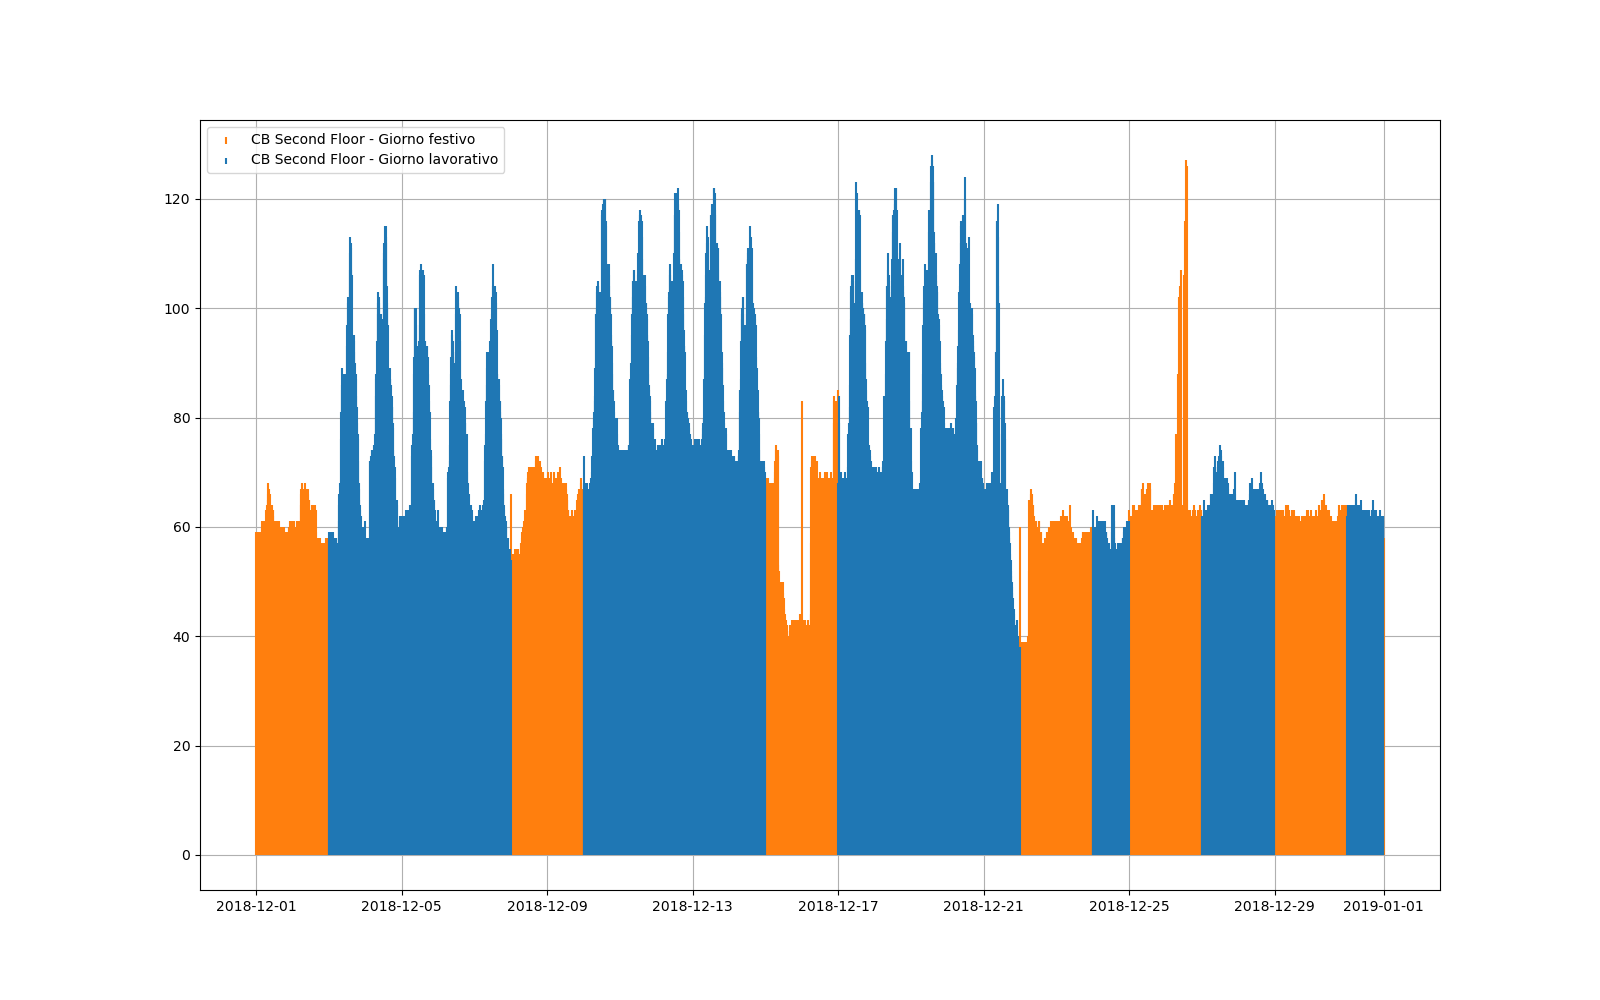

In [13]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
curr_dataset = train
# curr_dataset = curr_dataset[('2017-12-01' <= curr_dataset['DateTime'])&(curr_dataset['DateTime'] <= '2018-02-01')]
curr_dataset = curr_dataset[('2018-12-01' <= curr_dataset['DateTime'])&(curr_dataset['DateTime'] <= '2019-01-01')]

#curr_dataset = curr_dataset[curr_dataset['DateTime'].dt.day < 12]


curr_holidays = curr_dataset[(curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5)]
curr_not_holidays = curr_dataset[~((curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5))]


ax.stem(curr_holidays.index, curr_holidays['AvgP2'], label='CB Second Floor - Giorno festivo', linefmt='C1', markerfmt=' ', basefmt=' ')
ax.stem(curr_not_holidays.index, curr_not_holidays['AvgP2'], label='CB Second Floor - Giorno lavorativo', linefmt='C0', markerfmt=' ', basefmt=' ')

ax.grid()
ax.legend()
plt.show()


# Fotovoltaico
CB Third Floor

<IPython.core.display.Javascript object>


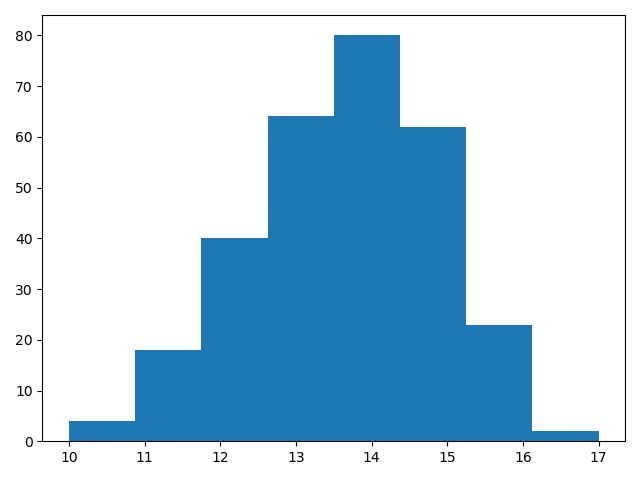

In [10]:
# ore con potenza negativa
fig, ax = plt.subplots(1, 1, tight_layout=True)
hours = train[train['AvgP3']<0]['DateTime'].dt.hour
ax.hist(hours, bins=len(hours.unique()))
plt.show()

<IPython.core.display.Javascript object>


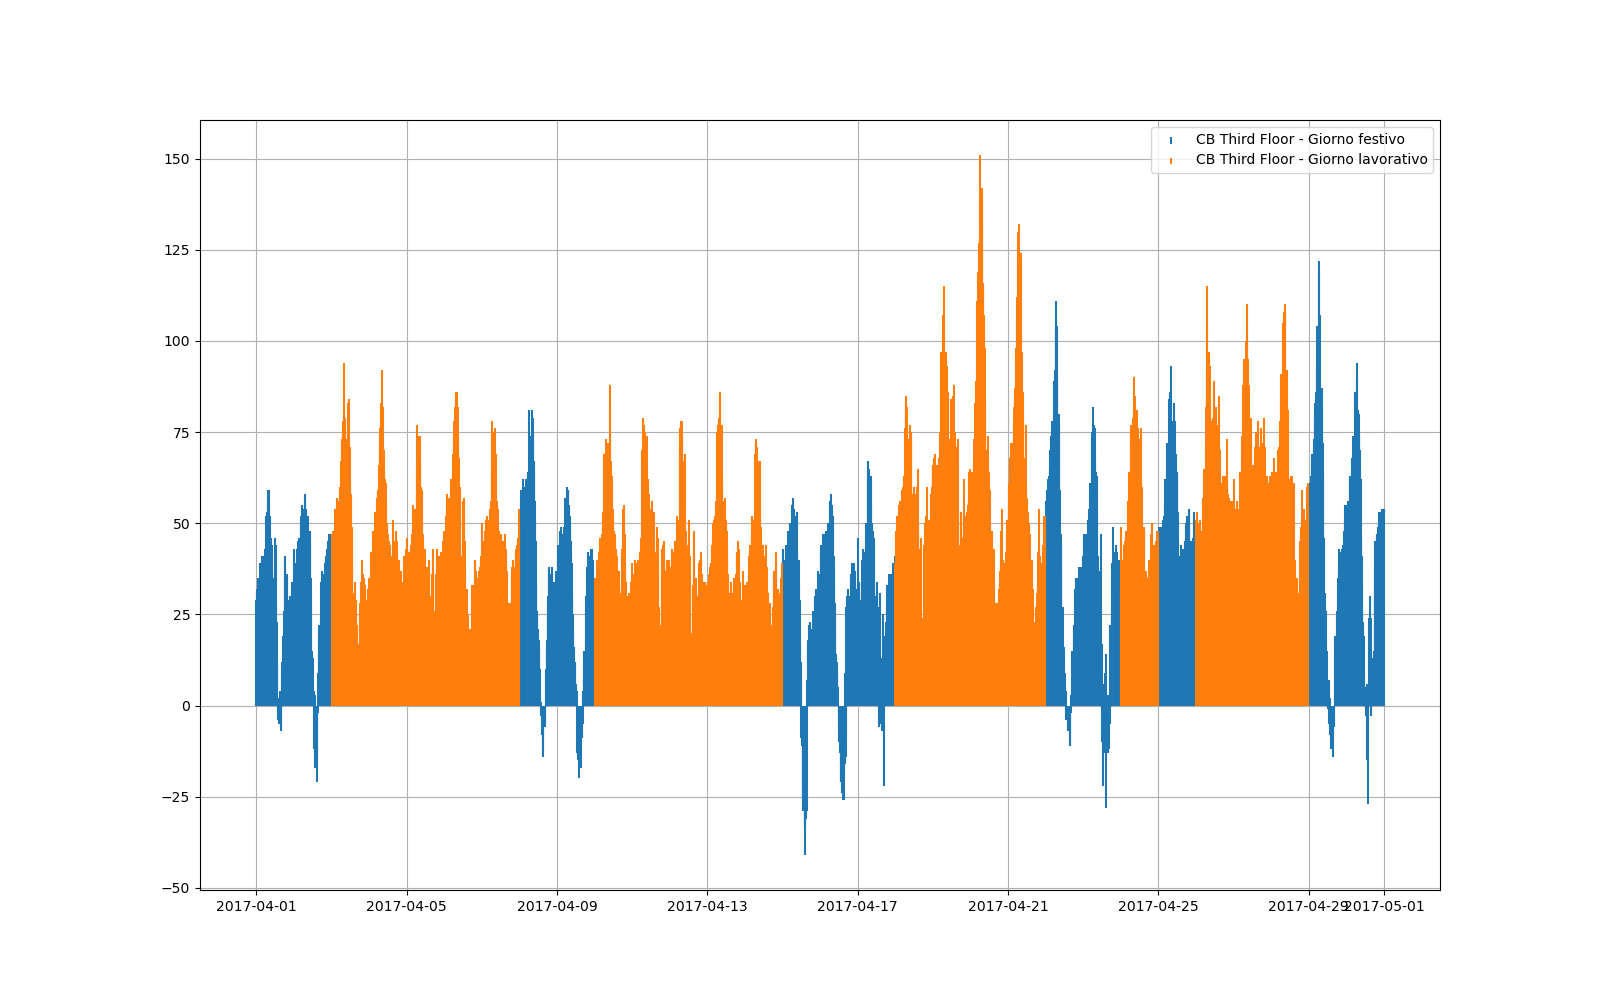

In [11]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
curr_dataset = train
curr_dataset = curr_dataset[curr_dataset['DateTime'].dt.year == 2017]
curr_dataset = curr_dataset[curr_dataset['DateTime'].dt.month == 4]

curr_holidays = curr_dataset[(curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5)]
curr_not_holidays = curr_dataset[~((curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5))]


ax.stem(curr_holidays.index, curr_holidays['AvgP3'], label='CB Third Floor - Giorno festivo', linefmt='C0', markerfmt=' ', basefmt=' ')
ax.stem(curr_not_holidays.index, curr_not_holidays['AvgP3'], label='CB Third Floor - Giorno lavorativo', linefmt='C1', markerfmt=' ', basefmt=' ')

#ax.plot(curr_dataset.index, curr_dataset['holidays'], label='hol')

ax.grid()
ax.legend()
plt.show()